## Load Data

In [275]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import norm
import math
import geopandas as gpd
from shapely.geometry import Point, Polygon

# model stuff
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler
from xgboost import XGBRegressor

In [276]:
# import housing data
raw_train = pd.read_csv('../Data/EdmontonRealEstateData_train.csv')
raw_test = pd.read_csv('../Data/EdmontonRealEstateData_test.csv')

## Exploratory Data Analysis

In [277]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42779 entries, 0 to 42778
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  42779 non-null  int64  
 1   taxroll_number              42779 non-null  int64  
 2   landuse_description         42779 non-null  object 
 3   market_building_class       40471 non-null  object 
 4   effective_build_year        40455 non-null  float64
 5   net_area                    42779 non-null  float64
 6   basement_finished           42779 non-null  object 
 7   has_garage                  42779 non-null  object 
 8   has_fireplace               42779 non-null  object 
 9   assessed_value              42779 non-null  int64  
 10  house_suit                  0 non-null      float64
 11  house_number                42779 non-null  int64  
 12  house_suff                  18 non-null     object 
 13  street_name                 427

In [278]:
raw_train.isna().sum().sort_values(ascending=False)

house_suit                    42779
house_suff                    42761
postal_code                    2492
effective_build_year           2324
site_coverage                  2323
market_building_class          2308
build_year_mbc                 2308
fully_complete                 2304
Unnamed: 0                        0
building_count                    0
walkout_basement                  0
air_conditioning                  0
display_type                      0
valuation_group                   0
tot_gross_area_description        0
geometry                          0
result_code                       0
lon                               0
lot_size                          0
full_address                      0
fully_taxable                     0
neighbourhood                     0
taxroll_number                    0
city                              0
street_name                       0
house_number                      0
assessed_value                    0
has_fireplace               

<AxesSubplot:>

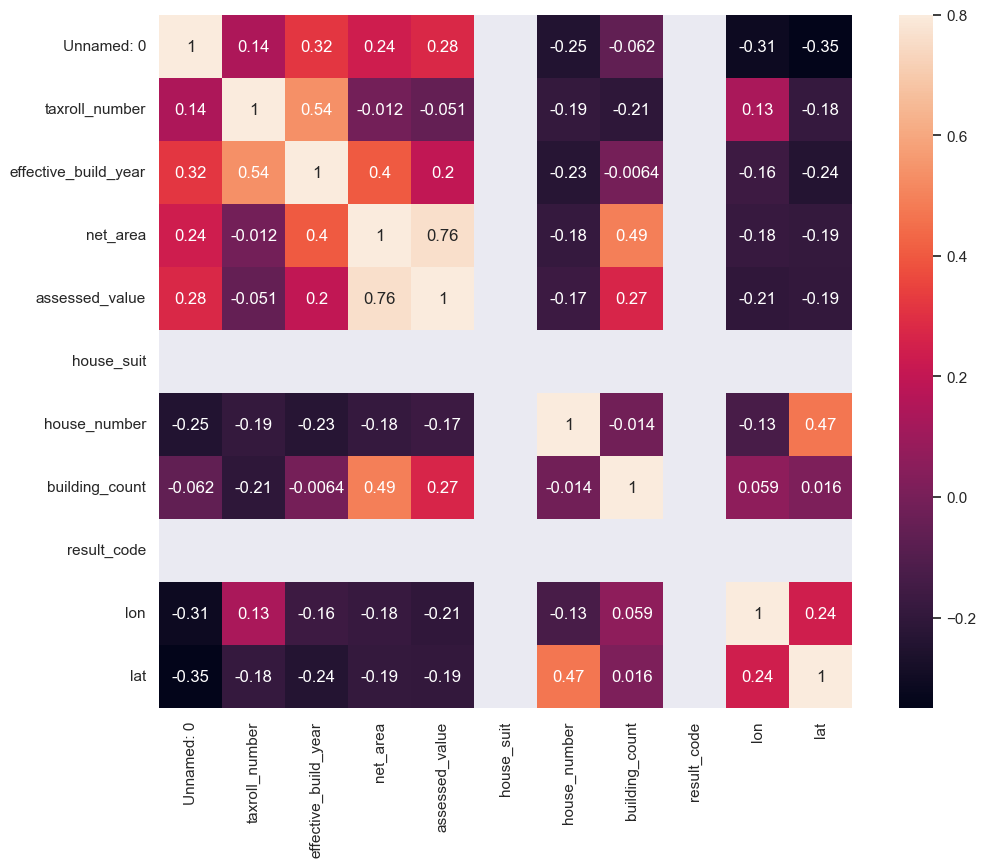

In [279]:
# correlation matrix
corrmat = raw_train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,annot=True, vmax=0.8, square=True)

In [280]:
raw_train['assessed_value'].describe()

count    4.277900e+04
mean     4.770349e+05
std      2.583694e+05
min      4.150000e+04
25%      3.485000e+05
50%      4.225000e+05
75%      5.365000e+05
max      8.447500e+06
Name: assessed_value, dtype: float64

<AxesSubplot:xlabel='assessed_value', ylabel='Count'>

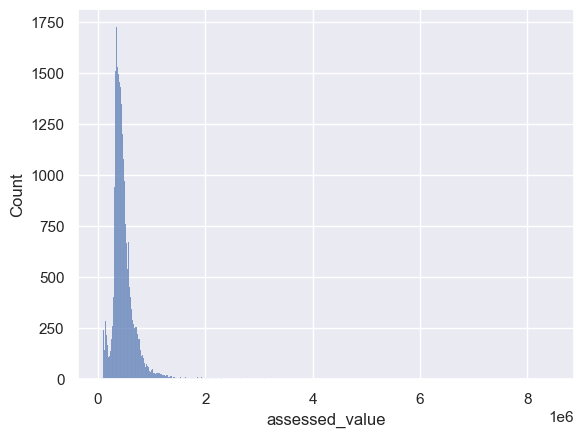

In [281]:
sns.histplot(raw_train['assessed_value'])

<AxesSubplot:xlabel='net_area', ylabel='assessed_value'>

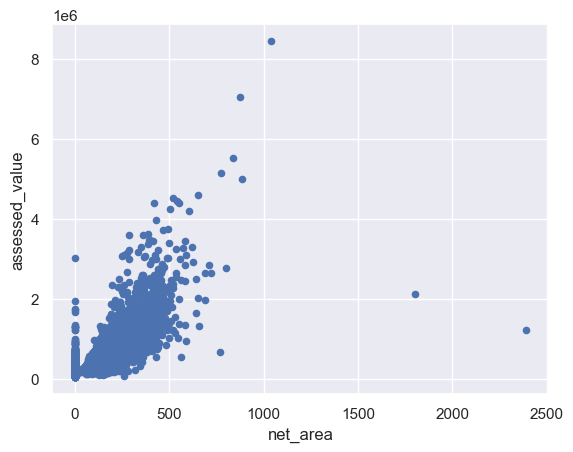

In [282]:
data = pd.concat([raw_train['assessed_value'], raw_train['net_area']], axis=1)
data.plot.scatter(x='net_area', y='assessed_value')

<AxesSubplot:xlabel='net_area', ylabel='Count'>

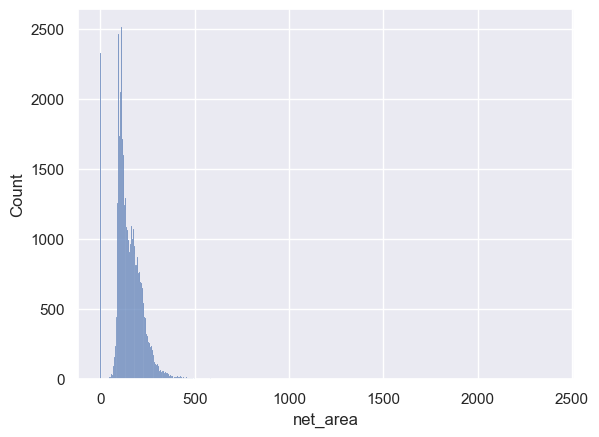

In [283]:
sns.histplot(raw_train['net_area'])

In [284]:
df = raw_train
df = df[(df['assessed_value'] >= np.percentile(df['assessed_value'], 0.5)) &
       (df['assessed_value'] <= np.percentile(df['assessed_value'], 99.5)) &
       (df['lat'] >= np.percentile(df['lat'], 0.05)) &
       (df['lat'] < np.percentile(df['lat'], 99.95)) &
       (df['lon'] >= np.percentile(df['lon'], 0.05)) &
       (df['lon'] <= np.percentile(df['lon'], 99.95))]

In [285]:
street_map = gpd.read_file('../Data/Neighbourhood_Boundaries/geo_export_89c8073e-fe24-4f48-981c-18aca8dbcc87.shp')
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geo_df = gpd.GeoDataFrame(df,geometry=geometry)

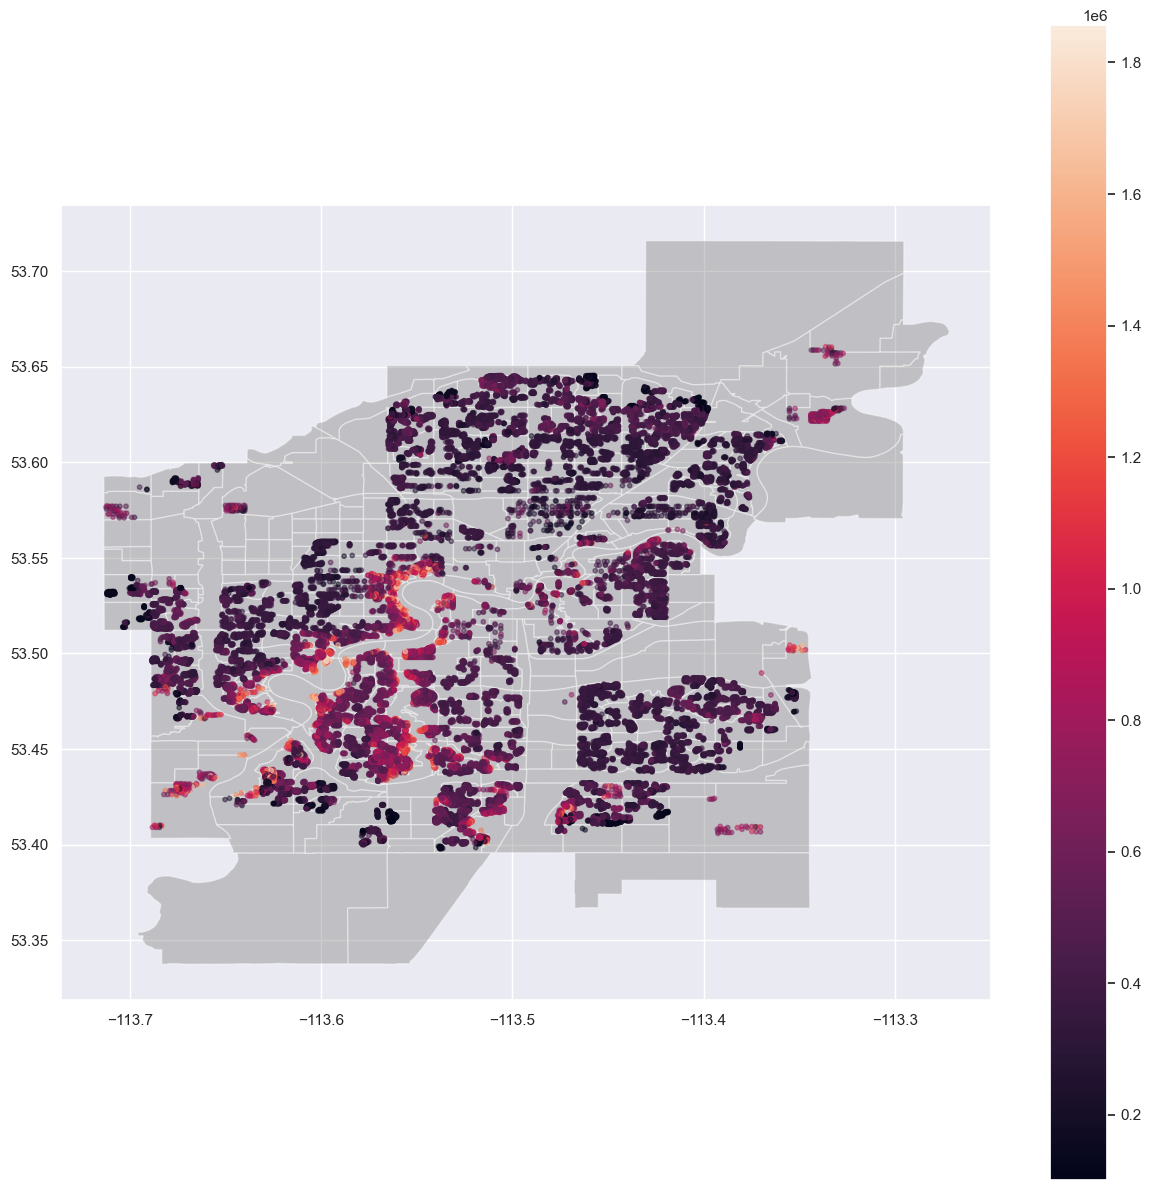

In [286]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(column='assessed_value', ax=ax, alpha=0.5, legend=True, markersize=10)
plt.show()

## Data Cleaning & Preprocessing

In [287]:
# drop columns with uninteresting parameters
train = raw_train.drop(['house_suit','house_number','house_suff','street_name', 'city', 'full_address', 'fully_taxable',\
                      'display_type', 'geometry', 'result_code', 'build_year_mbc','landuse_description', 'postal_code', 'effective_build_year', 'market_building_class'], axis=1)

test = raw_test.drop(['house_suit','house_number','house_suff','street_name', 'city', 'full_address', 'fully_taxable',\
                      'display_type', 'geometry', 'result_code', 'build_year_mbc','landuse_description','postal_code', 'effective_build_year', 'market_building_class'], axis=1)

# get rid of unnamed column
train = train.iloc[:,1:]

test = test.iloc[:,1:]

In [288]:
train.isna().sum().sort_values(ascending=False)

site_coverage                 2323
fully_complete                2304
taxroll_number                   0
building_count                   0
lon                              0
tot_gross_area_description       0
valuation_group                  0
air_conditioning                 0
walkout_basement                 0
lot_size                         0
net_area                         0
neighbourhood                    0
assessed_value                   0
has_fireplace                    0
has_garage                       0
basement_finished                0
lat                              0
dtype: int64

In [289]:
test.isna().sum().sort_values(ascending=False)

site_coverage                 629
fully_complete                624
taxroll_number                  0
building_count                  0
lon                             0
tot_gross_area_description      0
valuation_group                 0
air_conditioning                0
walkout_basement                0
lot_size                        0
net_area                        0
neighbourhood                   0
assessed_value                  0
has_fireplace                   0
has_garage                      0
basement_finished               0
lat                             0
dtype: int64

In [290]:
# fully_complete data is blank for undeveloped residential land, impute blank values as None
train['fully_complete'] = train['fully_complete'].fillna("NO")
test['fully_complete'] = test['fully_complete'].fillna("NO")

# incomplete site_coverage data is mainly undeveloped residential land, impute blank values with 0
train['site_coverage'] = train['site_coverage'].fillna("0%")
test['site_coverage'] = test['site_coverage'].fillna("0%")

train['site_coverage'] = train['site_coverage'].str.rstrip('%').astype('float') / 100.0
test['site_coverage'] = test['site_coverage'].str.rstrip('%').astype('float') / 100.0

# incomplete market_building_class is mainly undeveloped residential land, imput blank values with 'NO MARKET BUILDING CLASS'
#train['market_building_class'] = train['market_building_class'].fillna("NO MARKET BUILDING CLASS")
#test['market_building_class'] = test['market_building_class'].fillna("NO MARKET BUILDING CLASS")

In [291]:
test.isna().sum().sort_values(ascending=False)

taxroll_number                0
building_count                0
lon                           0
tot_gross_area_description    0
site_coverage                 0
valuation_group               0
air_conditioning              0
walkout_basement              0
lot_size                      0
net_area                      0
fully_complete                0
neighbourhood                 0
assessed_value                0
has_fireplace                 0
has_garage                    0
basement_finished             0
lat                           0
dtype: int64

In [292]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   taxroll_number              10695 non-null  int64  
 1   net_area                    10695 non-null  float64
 2   basement_finished           10695 non-null  object 
 3   has_garage                  10695 non-null  object 
 4   has_fireplace               10695 non-null  object 
 5   assessed_value              10695 non-null  int64  
 6   neighbourhood               10695 non-null  object 
 7   fully_complete              10695 non-null  object 
 8   lot_size                    10695 non-null  object 
 9   building_count              10695 non-null  int64  
 10  walkout_basement            10695 non-null  object 
 11  air_conditioning            10695 non-null  object 
 12  valuation_group             10695 non-null  object 
 13  site_coverage               106

In [293]:
# just keep m^2 value for tot_gross_area_description
train['tot_gross_area_description'] = train['tot_gross_area_description'].astype(str)
train['tot_gross_area_description'] = train['tot_gross_area_description'].str.split(' ',1,expand=True)[0]
train['tot_gross_area_description'] = train['tot_gross_area_description'].astype('float')

# just keep m^2 value for tot_gross_area_description
test['tot_gross_area_description'] = test['tot_gross_area_description'].astype(str)
test['tot_gross_area_description'] = test['tot_gross_area_description'].str.split(' ',1,expand=True)[0]
test['tot_gross_area_description'] = test['tot_gross_area_description'].astype('float')

In [294]:
# just keep m^2 value lot_size
train['lot_size'] = train['lot_size'].astype(str)
train['lot_size'] = train['lot_size'].str.split(' ',1,expand=True)[0]
train['lot_size'] = train['lot_size'].astype('float')

test['lot_size'] = test['lot_size'].astype(str)
test['lot_size'] = test['lot_size'].str.split(' ',1,expand=True)[0]
test['lot_size'] = test['lot_size'].astype('float')

In [295]:
# encode some categorical variables
train['basement_finished'] = train['basement_finished'].map({'Yes': 1, 'NO': 0})
train['has_garage'] = train['has_garage'].map({'Yes': 1, 'NO': 0})
train['has_fireplace'] = train['has_fireplace'].map({'Yes': 1, 'NO': 0})
train['walkout_basement'] = train['walkout_basement'].map({'Yes': 1, 'NO': 0})
train['air_conditioning'] = train['air_conditioning'].map({'Yes': 1, 'NO': 0})
train['fully_complete'] = train['fully_complete'].map({'Yes': 1, 'NO': 0})

test['basement_finished'] = test['basement_finished'].map({'Yes': 1, 'NO': 0})
test['has_garage'] = test['has_garage'].map({'Yes': 1, 'NO': 0})
test['has_fireplace'] = test['has_fireplace'].map({'Yes': 1, 'NO': 0})
test['walkout_basement'] = test['walkout_basement'].map({'Yes': 1, 'NO': 0})
test['air_conditioning'] = test['air_conditioning'].map({'Yes': 1, 'NO': 0})
test['fully_complete'] = test['fully_complete'].map({'Yes': 1, 'NO': 0})

In [296]:
# categorize valuation group
train['valuation_group'] = train['valuation_group'].map({
    'RESIDENTIAL SOUTH': 0,
    'RESIDENTIAL NORTH': 1,
    'RESIDENTIAL WC': 2,
    'RESIDENTIAL RIVVAL': 3,
    'RESIDENTIAL LAND': 4,
    'SPECIAL PURPOSE': 5,
    'LAND': 6
})

test['valuation_group'] = test['valuation_group'].map({
    'RESIDENTIAL SOUTH': 0,
    'RESIDENTIAL NORTH': 1,
    'RESIDENTIAL WC': 2,
    'RESIDENTIAL RIVVAL': 3,
    'RESIDENTIAL LAND': 4,
    'SPECIAL PURPOSE': 5,
    'LAND': 6
})

labelencoder = LabelEncoder()
train['neighbourhood'] = labelencoder.fit_transform(train['neighbourhood'])
test['neighbourhood'] = labelencoder.fit_transform(test['neighbourhood'])

In [297]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   taxroll_number              10695 non-null  int64  
 1   net_area                    10695 non-null  float64
 2   basement_finished           10695 non-null  int64  
 3   has_garage                  10695 non-null  int64  
 4   has_fireplace               10695 non-null  int64  
 5   assessed_value              10695 non-null  int64  
 6   neighbourhood               10695 non-null  int32  
 7   fully_complete              10695 non-null  int64  
 8   lot_size                    10695 non-null  float64
 9   building_count              10695 non-null  int64  
 10  walkout_basement            10695 non-null  int64  
 11  air_conditioning            10695 non-null  int64  
 12  valuation_group             10695 non-null  int64  
 13  site_coverage               106

## Exploratory Data Analysis Part 2

<AxesSubplot:>

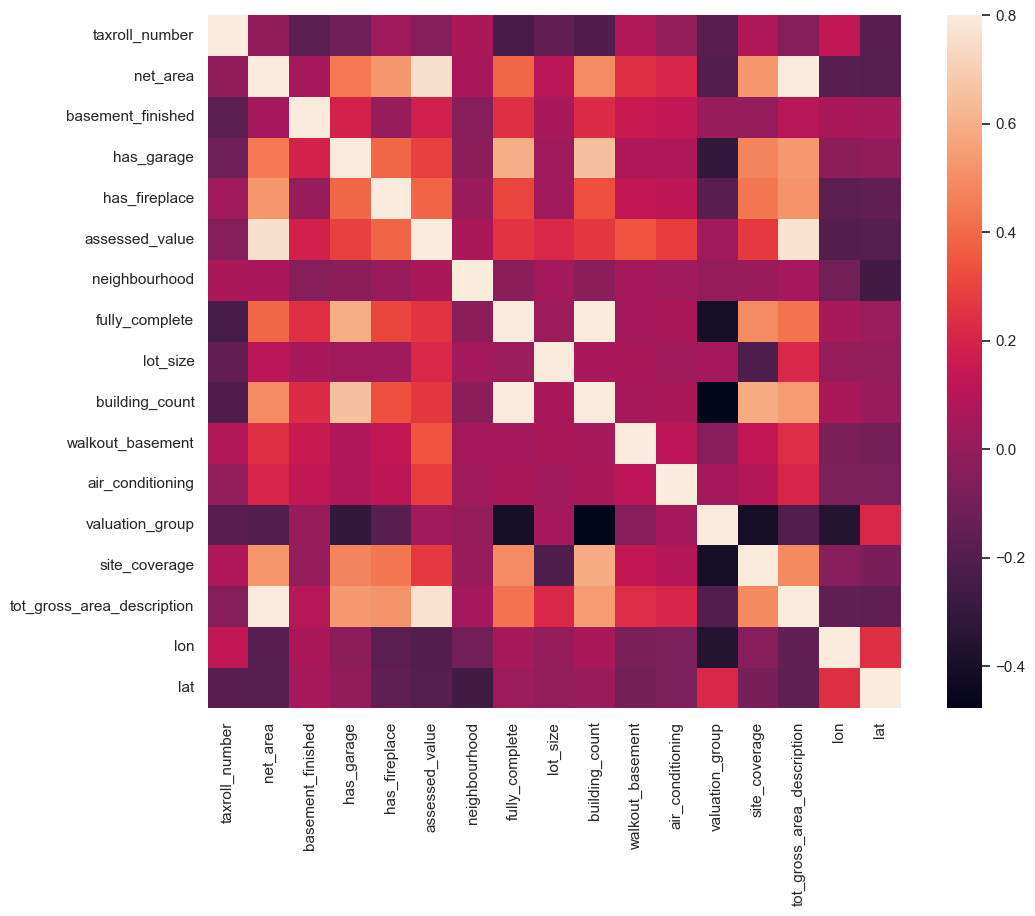

In [298]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

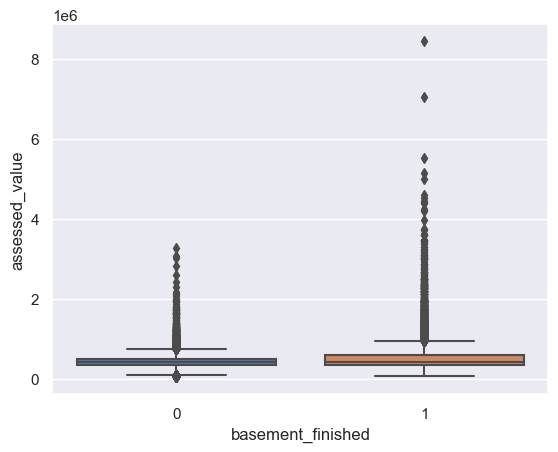

In [299]:
data = pd.concat([train['assessed_value'], train['basement_finished']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='basement_finished', y='assessed_value', data=data)

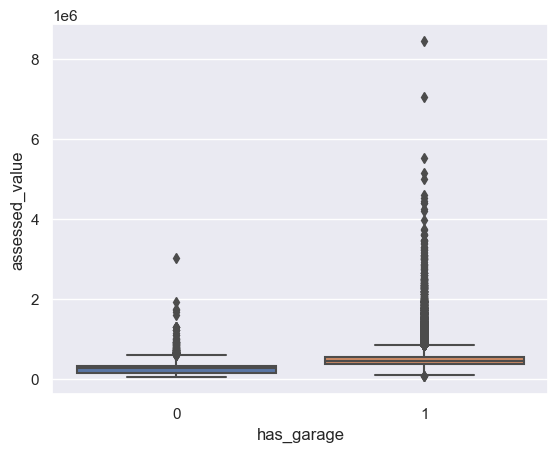

In [300]:
data = pd.concat([train['assessed_value'], train['has_garage']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='has_garage', y='assessed_value', data=data)

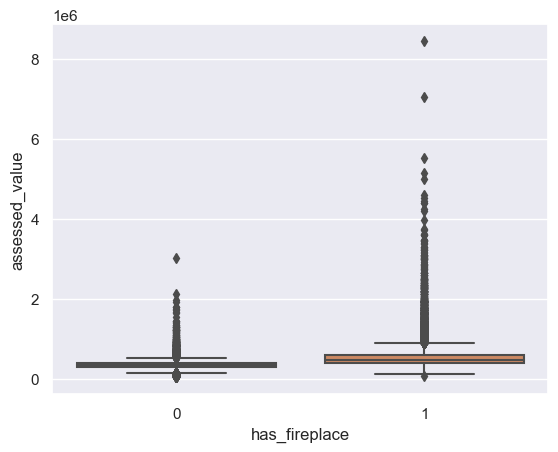

In [301]:
data = pd.concat([train['assessed_value'], train['has_fireplace']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='has_fireplace', y='assessed_value', data=data)

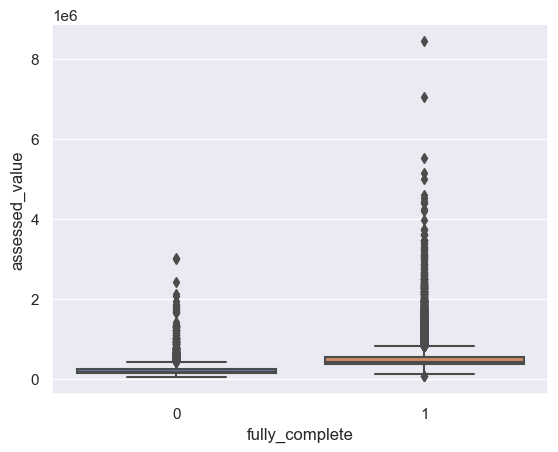

In [302]:
data = pd.concat([train['assessed_value'], train['fully_complete']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='fully_complete', y='assessed_value', data=data)

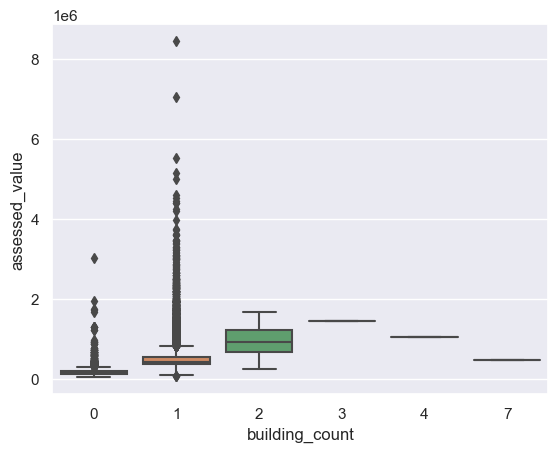

In [303]:
data = pd.concat([train['assessed_value'], train['building_count']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='building_count', y='assessed_value', data=data)

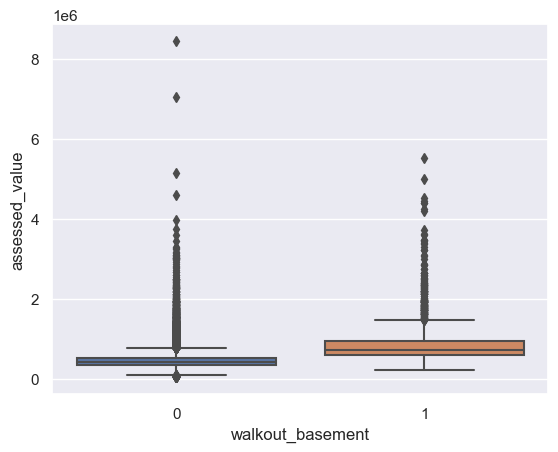

In [304]:
data = pd.concat([train['assessed_value'], train['walkout_basement']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='walkout_basement', y='assessed_value', data=data)

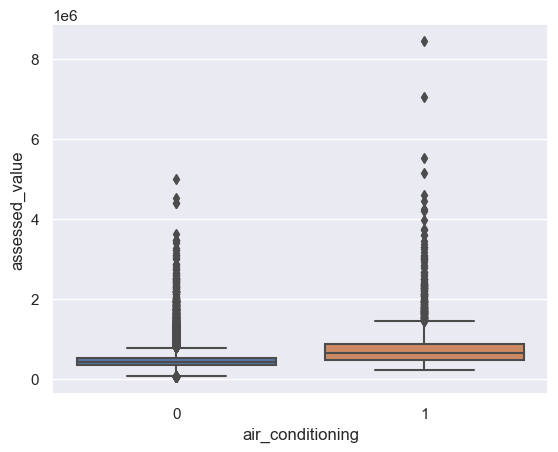

In [305]:
data = pd.concat([train['assessed_value'], train['air_conditioning']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='air_conditioning', y='assessed_value', data=data)

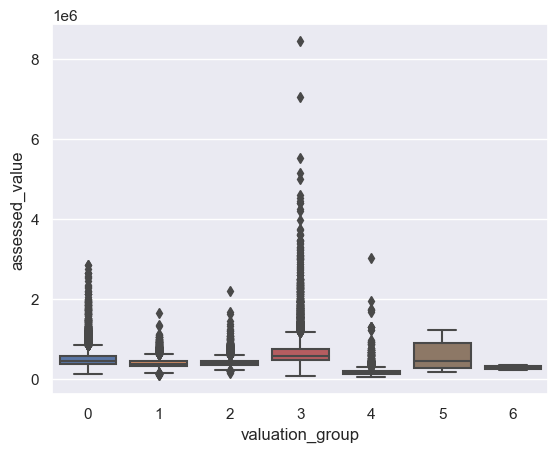

In [306]:
data = pd.concat([train['assessed_value'], train['valuation_group']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='valuation_group', y='assessed_value', data=data)

## Model

In [307]:
X_train = train.loc[:,['net_area', 'basement_finished', 'has_garage', 'has_fireplace', 'lot_size', 'building_count', 'walkout_basement', 'air_conditioning', 'valuation_group', 'tot_gross_area_description', 'fully_complete','lon', 'lat']]
Y_train = train['assessed_value']

X_test = test.loc[:,['net_area', 'basement_finished', 'has_garage', 'has_fireplace', 'lot_size', 'building_count', 'walkout_basement', 'air_conditioning', 'valuation_group', 'tot_gross_area_description', 'fully_complete','lon', 'lat']]
Y_test = test['assessed_value']

result = pd.DataFrame(columns=('Simple Linear Regression','Multi-Linear Regression','Ridge','LASSO','RFR','XGBoost'), index = ['MAPE', 'RSME', 'r2'])

### Simple Linear Regression

In [308]:
X_train_2 = train.loc[:,['net_area']]
Y_train_2 = train['assessed_value']

X_test_2 = test.loc[:,['net_area']]
Y_test_2 = test['assessed_value']

slr_fit = LinearRegression().fit(X_train_2, Y_train_2)
slr_pred = slr_fit.predict(X_test_2)
slr_err = mean_squared_error(Y_test_2, slr_pred)
slr_r2 = r2_score(Y_test_2, slr_pred)
slr_mape = mean_absolute_percentage_error(Y_test_2, slr_pred)

result['Simple Linear Regression'] = [slr_mape, math.sqrt(slr_err), slr_r2]

### Multi-Linear Regression

In [309]:
lin_fit = LinearRegression().fit(X_train, Y_train)
lin_pred = lin_fit.predict(X_test)
lin_err = mean_squared_error(Y_test, lin_pred)
lin_r2 = r2_score(Y_test, lin_pred)
lin_mape = mean_absolute_percentage_error(Y_test, lin_pred)

result['Multi-Linear Regression'] = [lin_mape, math.sqrt(lin_err), lin_r2]
for i in range(len(lin_fit.coef_)):
    print(X_train.columns[i],lin_fit.coef_[i])

net_area 993.7593315651359
basement_finished 58878.605711849705
has_garage -45856.350014452786
has_fireplace -3020.270259920184
lot_size 13.365994488631259
building_count -301026.5866864521
walkout_basement 159223.8264226598
air_conditioning 86876.22676466845
valuation_group 31708.80785117895
tot_gross_area_description 1599.2500253949693
fully_complete 205761.40921671508
lon 53861.83679766093
lat -294834.67001888505


### Ridge Regression

In [310]:
ridge = linear_model.Ridge(alpha=0.1)
ridge_fit = ridge.fit(X_train, Y_train)
ridge_pred = ridge.predict(X_test)
ridge_err = mean_squared_error(Y_test, ridge_pred)
ridge_r2 = r2_score(Y_test, ridge_pred)
ridge_mape = mean_absolute_percentage_error(Y_test, ridge_pred)

result['Ridge'] = [ridge_mape, math.sqrt(ridge_err), ridge_r2]
for i in range(len(ridge_fit.coef_)):
    print(X_train.columns[i],ridge_fit.coef_[i])

net_area 993.837439322161
basement_finished 58879.76627525762
has_garage -45859.53479489391
has_fireplace -3018.2109062813033
lot_size 13.366500288526725
building_count -300949.00828861824
walkout_basement 159217.7247341883
air_conditioning 86877.1293116801
valuation_group 31705.582256214897
tot_gross_area_description 1599.1655830840252
fully_complete 205692.53758486724
lon 53791.71161297318
lat -294664.4135875294


### Lasso

In [311]:
# hyperparameter tuning
#param_grid = {
    #"lasso__alpha": [pow(10, x) for x in range(-2, 2, 1)]
#}

#tuned_lasso = GridSearchCV(
#    models['base_lasso'], 
#)

In [312]:
lasso = linear_model.Lasso(alpha=0.1)
lasso_fit = lasso.fit(X_train, Y_train)
lasso_predict = lasso.predict(X_test)
lasso_error = mean_squared_error(Y_test, lasso_predict)
lasso_r2 = r2_score(Y_test, lasso_predict)
lasso_mape = mean_absolute_percentage_error(Y_test, lasso_predict)

result['LASSO'] = [lasso_mape, math.sqrt(lasso_error), lasso_r2]
for i in range(len(lasso_fit.coef_)):
    print(X_train.columns[i],lasso_fit.coef_[i])

net_area 993.7719209948795
basement_finished 58878.85816279187
has_garage -45855.31875695424
has_fireplace -3019.7569767430014
lot_size 13.366161941750418
building_count -301015.3470825629
walkout_basement 159221.72086020355
air_conditioning 86875.14968513478
valuation_group 31707.743580093742
tot_gross_area_description 1599.2335962772406
fully_complete 205749.26548233576
lon 53836.24665265164
lat -294803.9103722421


### Random Forest

In [313]:
RFR = RandomForestRegressor(n_estimators=500)
RFR_fit = RFR.fit(X_train, Y_train)
RFR_pred = RFR.predict(X_test)
RFR_err = mean_squared_error(Y_test, RFR_pred)
RFR_r2 = r2_score(Y_test, RFR_pred)
RFR_mape = mean_absolute_percentage_error(Y_test, RFR_pred)

result['RFR'] = [RFR_mape, math.sqrt(RFR_err), RFR_r2]

### XGBoost

In [314]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, Y_train, verbose=False)
xgb_pred = xgb.predict(X_test)
xgb_err = mean_squared_error(Y_test, xgb_pred)
xgb_r2 = r2_score(Y_test, xgb_pred)
xgb_mape = mean_absolute_percentage_error(Y_test, xgb_pred)

result['XGBoost'] = [xgb_mape, math.sqrt(xgb_err), xgb_r2]

In [315]:
result

,Simple Linear Regression,Multi-Linear Regression,Ridge,LASSO,RFR,XGBoost
MAPE,0.190200,0.150843,0.150839,0.150842,0.056902,0.061375
RSME,188623.664151,161030.061762,161029.844207,161030.052626,111752.857943,120457.888659
r2,0.568982,0.685865,0.685865,0.685865,0.848706,0.824218
